```markdown
MACHINE LEARNING EMG PROJECT
```
``
Project Workflow
``
`
Data pre-processing
`
Feature Design
`
Develelopment of Models
`
Training
`

In [47]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


#  Data Cleaning

In [48]:
#readin in the data
df = pd.read_csv('Project_Data_EE4C12_S&S_EMG.csv')
classes=np.array([
    'unmarked data',
    'hand at rest',
    'hand clenched in a fist',
    'wrist flexion',
    'wrist extension',
    'radial deviations',
    'ulnar deviations',
    'extended palm'
])

print(df.head())
print(df.shape)
num_samples = df.shape[0]



   time  channel1  channel2  channel3  channel4  channel5  channel6  channel7  \
0     1   0.00001  -0.00002  -0.00001  -0.00003   0.00000  -0.00001   0.00000   
1     5   0.00001  -0.00002  -0.00001  -0.00003   0.00000  -0.00001   0.00000   
2     6  -0.00001   0.00001   0.00002   0.00000   0.00001  -0.00002  -0.00001   
3     7  -0.00001   0.00001   0.00002   0.00000   0.00001  -0.00002  -0.00001   
4     8  -0.00001   0.00001   0.00002   0.00000   0.00001  -0.00002  -0.00001   

   channel8  class  label  
0  -0.00001      0      1  
1  -0.00001      0      1  
2   0.00001      0      1  
3   0.00001      0      1  
4   0.00001      0      1  
(4237907, 11)


`
check for n/a values
`

In [49]:
na_counts = df.isna().sum()
display(na_counts.T)

time        0
channel1    0
channel2    0
channel3    0
channel4    0
channel5    0
channel6    0
channel7    0
channel8    0
class       0
label       0
dtype: int64

In [50]:

print("There are " + str(df['label'].nunique()) + " unique subjects in the dataset (different people performing the gestures).")
grouped_df = df.groupby(['label', 'class']).size().unstack(fill_value=0)
display(grouped_df.T)

There are 36 unique subjects in the dataset (different people performing the gestures).


label     1      2      3      4      5      6      7      8      9      10  \
class                                                                         
0      78682  94654  67770  72578  68057  61128  82641  80264  90407  81875   
1       7311   7140   6443   6471   6506   5814   7523   6468   7083   7690   
2       6806   6777   6301   6598   6806   6243   7651   6537   6019   6571   
3       7329   6815   6486   6875   6874   6663   8383   5939   5838   6534   
4       6824   6812   6421   7193   6724   6688   8923   6027   5776   6766   
5       7075   6856   6278   7423   6098   7094   8414   6237   6050   6658   
6       7143   7372   6086   7060   6183   5989   9105   6476   6474   6995   
7          0      0      0      0      0      0      0      0      0      0   

label  ...     27     28     29     30     31     32     33     34     35  \
class  ...                                                                  
0      ...  64660  64522  64093  98180  53642  75148  73298  85693  60383   
1      ...   7167   5232   6317   8047   6924   6650   7082   7553   6703   
2      ...   6686   5628   6460   7279   5975   8085   6316   7458   6247   
3      ...   6654   5488   7495   7480   6197   8271   6127   7274   6422   
4      ...   7309   5733   7059   7061   6180   8386   6527   7732   6653   
5      ...   7405   5245   7261   6700   6028   8604   6225   7710   6897   
6      ...   6918   5918   7302   7223   6077   7786   6530   7782   6196   
7      ...      0      0      0   6591      0      0      0      0      0   

label     36  
class         
0      65538  
1       6391  
2       6093  
3       6078  
4       5926  
5       5743  
6       5985  
7          0  

[8 rows x 36 columns]

Percentage of samples for each class relative to the total number of samples:

Percentage of samples for class 0 relative to the total number of samples: 64.30%
Percentage of samples for class 1 relative to the total number of samples: 5.90%
Percentage of samples for class 2 relative to the total number of samples: 5.74%
Percentage of samples for class 3 relative to the total number of samples: 5.89%
Percentage of samples for class 4 relative to the total number of samples: 5.94%
Percentage of samples for class 5 relative to the total number of samples: 5.94%
Percentage of samples for class 6 relative to the total number of samples: 5.97%
Percentage of samples for class 7 relative to the total number of samples: 0.32%


Number of nonzero elements for class 7: 2, for patients (array([10, 29]),)


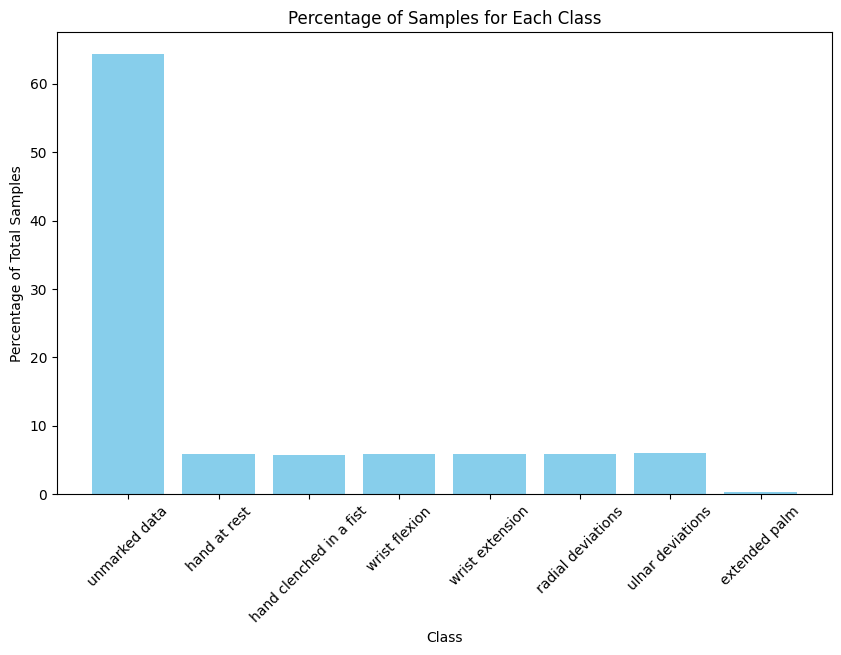

In [51]:
nonzero_count = np.count_nonzero(grouped_df.T.iloc[7])
print(f"Percentage of samples for each class relative to the total number of samples:\n")
for i in range(8):
    nonzero_count = np.count_nonzero(grouped_df.T.iloc[i])
    print(f"Percentage of samples for class {i} relative to the total number of samples: {np.sum(grouped_df.T.iloc[i])/num_samples*100:.2f}%")

print(f"\n\nNumber of nonzero elements for class {i}: {nonzero_count}, for patients {np.nonzero(grouped_df.T.iloc[7])}")

# Calculate the percentages
percentages = [np.sum(grouped_df.T.iloc[i]) / num_samples * 100 for i in range(8)]
# Plot the percentages
plt.figure(figsize=(10, 6))
plt.bar(classes[:8], percentages, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Percentage of Total Samples')
plt.title('Percentage of Samples for Each Class')
plt.xticks(rotation=45)
plt.show()


`
Due to the limited information available on class 7 it was decided that we would only classify on the first 6 classes
`

In [52]:

df_preprocessed = df[df['class'] != 7]
df_preprocessed = df_preprocessed[df_preprocessed['class'] != 0]
num_samples_processed = df_preprocessed.shape[0]
grouped_df_preprocess = df_preprocessed.groupby(['label', 'class']).size()
classes_preprocessed = classes[1:7]
for i in range(6):
    nonzero_count = np.count_nonzero(grouped_df_preprocess.T.iloc[i])
    print(f"Percentage of samples for class {i} relative to the total number of samples: {np.sum(grouped_df_preprocess.T.iloc[i])/num_samples_processed*100:.2f}%")

#  Calculate the percentages
percentages = [np.sum(grouped_df_preprocess.T.iloc[i]) / num_samples_processed * 100 for i in range(0,6)]
# Plot the percentages
plt.figure(figsize=(10, 6))
plt.bar(classes_preprocessed, percentages, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Percentage of Total Samples')
plt.title('Percentage of Samples for Each Class')
plt.xticks(rotation=45)
plt.show()

Percentage of samples for class 0 relative to the total number of samples: 0.49%
Percentage of samples for class 1 relative to the total number of samples: 0.45%
Percentage of samples for class 2 relative to the total number of samples: 0.49%
Percentage of samples for class 3 relative to the total number of samples: 0.46%
Percentage of samples for class 4 relative to the total number of samples: 0.47%
Percentage of samples for class 5 relative to the total number of samples: 0.48%


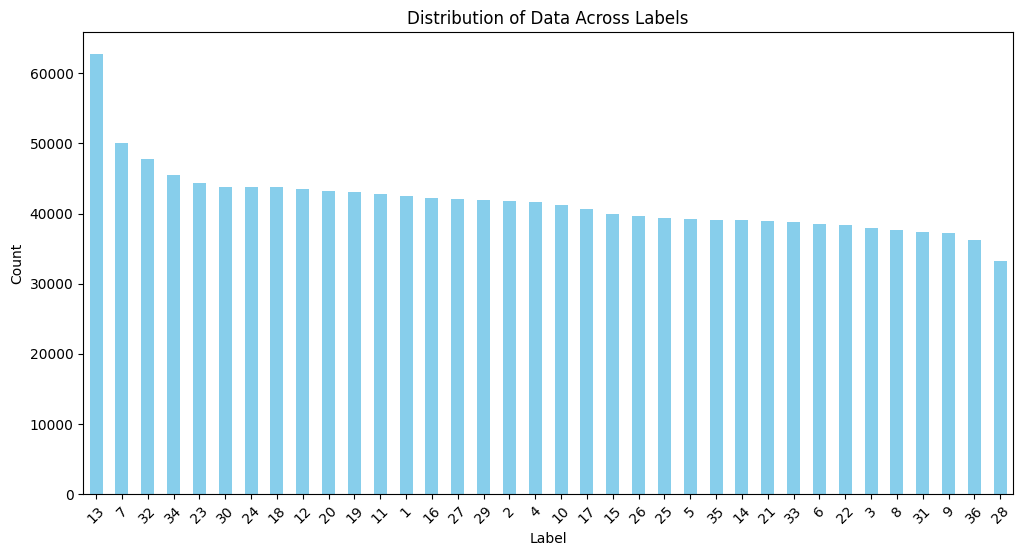

In [53]:
# Count the occurrences of each label
label_counts = df_preprocessed['label'].value_counts()

# Plot the distribution
plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Data Across Labels')
plt.xticks(rotation=45)
plt.show()

``
Lets us visualise the data
``

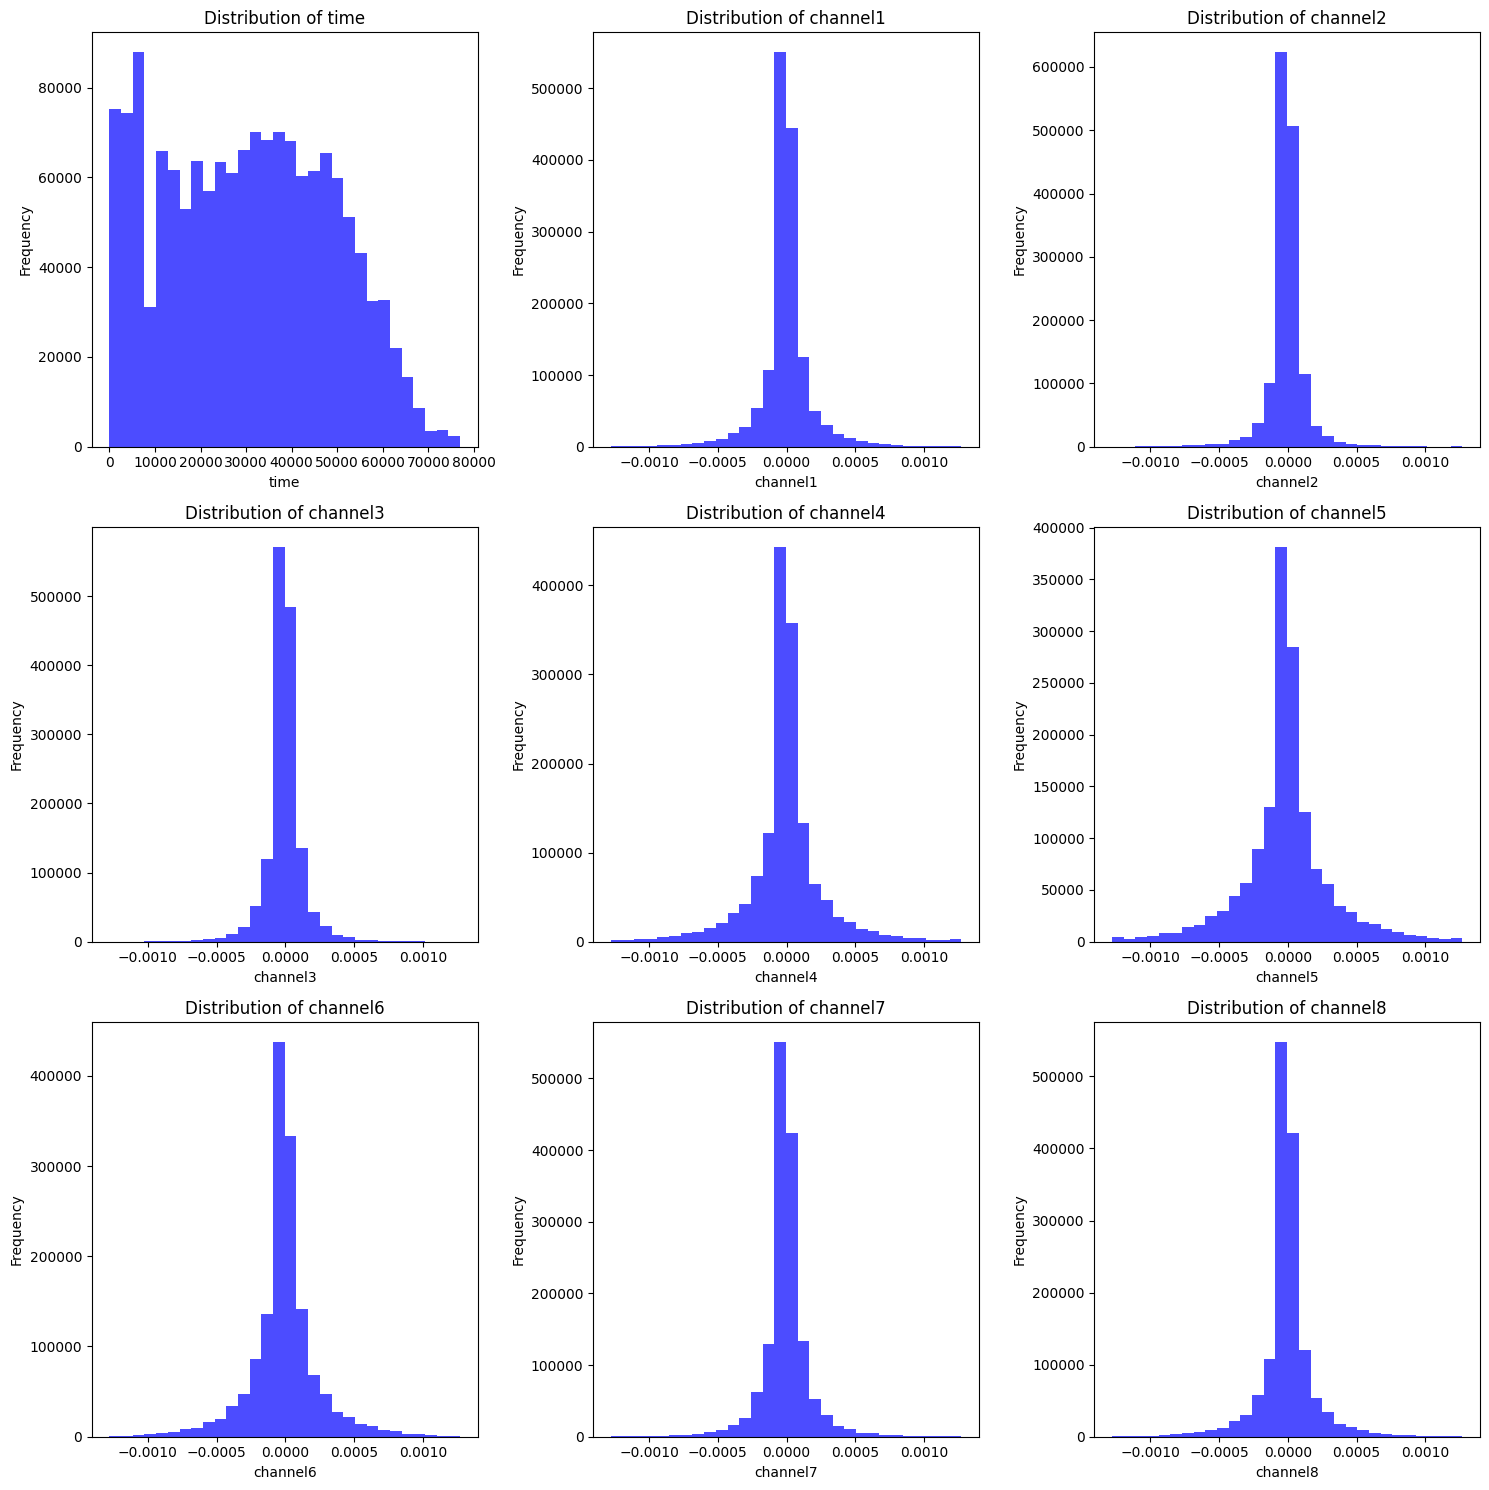

In [54]:
# Select only the feature columns (assuming there are 9 features)
feature_columns = df_preprocessed.columns[0:9]

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot the distribution of each feature
for i, feature in enumerate(feature_columns):
    axes[i].hist(df_preprocessed[feature], bins=30, alpha=0.7, color='b')
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

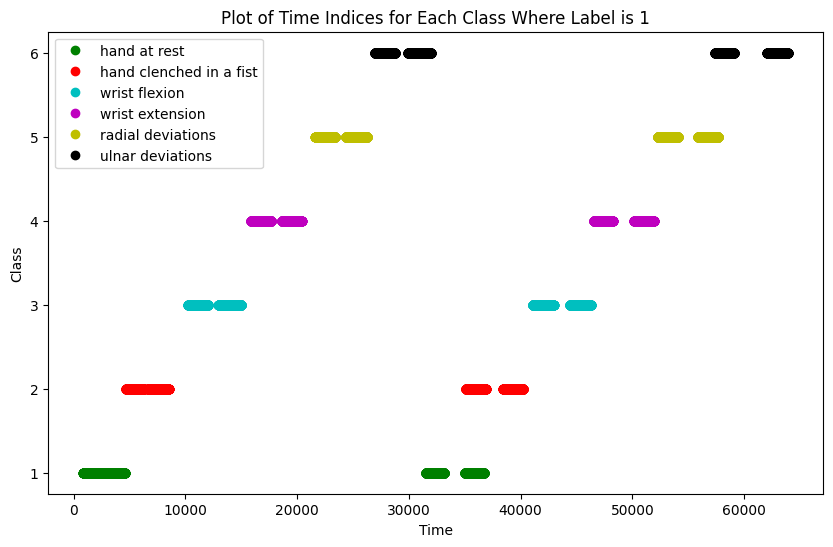

time  channel1  channel2  channel3  channel4  channel5  channel6  \
64012   880  -0.00003  -0.00004  -0.00006  -0.00006  -0.00004  -0.00002   
64013   881  -0.00003  -0.00004  -0.00006  -0.00006  -0.00004  -0.00002   
64014   882  -0.00003  -0.00004  -0.00006  -0.00006  -0.00004  -0.00002   
64015   883  -0.00003  -0.00004  -0.00006  -0.00006  -0.00004  -0.00002   
64016   884  -0.00003  -0.00004  -0.00006  -0.00006  -0.00004  -0.00002   
...     ...       ...       ...       ...       ...       ...       ...   
4397   4576  -0.00002   0.00002   0.00000   0.00000   0.00000   0.00001   
4398   4577  -0.00002   0.00002   0.00000   0.00000   0.00000   0.00001   
4399   4578  -0.00002   0.00002   0.00000   0.00000   0.00000   0.00001   
4400   4579  -0.00002   0.00002   0.00000   0.00000   0.00000   0.00001   
4401   4580  -0.00002   0.00002   0.00000   0.00000   0.00000   0.00001   

       channel7  channel8  class  label  
64012  -0.00001  -0.00002      1      1  
64013  -0.00001  -0.00002      1      1  
64014  -0.00001  -0.00002      1      1  
64015  -0.00001  -0.00002      1      1  
64016  -0.00001  -0.00002      1      1  
...         ...       ...    ...    ...  
4397    0.00001   0.00000      1      1  
4398    0.00001   0.00000      1      1  
4399    0.00001   0.00000      1      1  
4400    0.00001   0.00000      1      1  
4401    0.00001   0.00000      1      1  

[4049 rows x 11 columns]

In [55]:
# Define the colors for each class
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Create a figure
plt.figure(figsize=(10, 6))

# Iterate through each class and plot the markers
for class_value in range(1,7,1):  # Classes are labeled from 0 to 7
    subset = df_preprocessed[(df_preprocessed['label'] == 1) & (df_preprocessed['class'] == class_value) ]#& (df_preprocessed['time'] > 33000)
    plt.plot(subset['time'], subset['class'], 'o', label=f'Class {class_value}', color=colors[class_value])

# Customize the plot
plt.xlabel('Time')
plt.ylabel('Class')
plt.title('Plot of Time Indices for Each Class Where Label is 1')
plt.legend(classes_preprocessed)
plt.show()


subset = df_preprocessed[(df_preprocessed['label'] == 1) & (df_preprocessed['class'] == 1) & (df_preprocessed['time'] < 10000)]
subset = subset.sort_values(by='time')
subset

# Feature extraction/selection

### Window each gesture 
#### separate gestures if there is a gap in time

In [56]:
#loop through 36 labels (subjects)
#separate dataframe parts based on the 6 classes, 
# separate gesture data if there is a time gap between data (empty space)
# save the data in a dictionary with the label and class as the key

# Initialize an empty dictionary to store the separated data
data_dict = {}

# Define the time gap threshold (adjust as needed)
time_gap_threshold = 60000  # Example threshold

# Loop through each label (subject)
for label in range(1,37):
    # Loop through each class
    for class_value in range(1,7,1):
        # Filter the DataFrame for the current label and class
        subset = df_preprocessed[(df_preprocessed['label'] == label) & (df_preprocessed['class'] == class_value)]
        
        # Sort by time to ensure proper segmentation
        subset = subset.sort_values(by='time')
        
        # Identify segments of data where there is a time gap
        segments = []
        current_segment = []
        previous_time = None
        
        for _, row in subset.iterrows():
            current_time = row['time']
            if previous_time is not None and (current_time - previous_time) > time_gap_threshold:
                # Save the current segment and start a new one
                if current_segment:
                    segments.append(pd.DataFrame(current_segment))
                current_segment = []
            current_segment.append(row)
            previous_time = current_time
        
        # Add the last segment if it exists
        if current_segment:
            segments.append(pd.DataFrame(current_segment))
        if len(segments)!=2:
            print(label, class_value,"  segment length is:",len(segments))
        # Save the segments in the dictionary with the label and class as the key
        # Drop the 'time' column from each segment
        segments = [segment.drop(columns=['time']) for segment in segments]
        
        # Save the segments in the dictionary with the label and class as the key
        data_dict[(label, class_value)] = segments

# data_dict now contains the separated data for each label and class

1 1   segment length is: 1
1 2   segment length is: 1
1 3   segment length is: 1
1 4   segment length is: 1
1 5   segment length is: 1
1 6   segment length is: 1
2 1   segment length is: 1
2 2   segment length is: 1
2 3   segment length is: 1
2 4   segment length is: 1
2 5   segment length is: 1
2 6   segment length is: 1
3 1   segment length is: 1
3 2   segment length is: 1
3 3   segment length is: 1
3 4   segment length is: 1
3 5   segment length is: 1
3 6   segment length is: 1
4 1   segment length is: 1
4 2   segment length is: 1
4 3   segment length is: 1
4 4   segment length is: 1
4 5   segment length is: 1
4 6   segment length is: 1
5 1   segment length is: 1
5 2   segment length is: 1
5 3   segment length is: 1
5 4   segment length is: 1
5 5   segment length is: 1
5 6   segment length is: 1
6 1   segment length is: 1
6 2   segment length is: 1
6 3   segment length is: 1
6 4   segment length is: 1
6 5   segment length is: 1
6 6   segment length is: 1
7 1   segment length is: 1
7

### Apply feature extraction on separated segments

In [57]:
data_dict[(1, 1)][0]
        

channel1  channel2  channel3  channel4  channel5  channel6  channel7  \
64012  -0.00003  -0.00004  -0.00006  -0.00006  -0.00004  -0.00002  -0.00001   
64013  -0.00003  -0.00004  -0.00006  -0.00006  -0.00004  -0.00002  -0.00001   
64014  -0.00003  -0.00004  -0.00006  -0.00006  -0.00004  -0.00002  -0.00001   
64015  -0.00003  -0.00004  -0.00006  -0.00006  -0.00004  -0.00002  -0.00001   
64016  -0.00003  -0.00004  -0.00006  -0.00006  -0.00004  -0.00002  -0.00001   
...         ...       ...       ...       ...       ...       ...       ...   
35393  -0.00002  -0.00006   0.00000   0.00000   0.00001   0.00002   0.00000   
35394  -0.00002  -0.00006   0.00000   0.00000   0.00001   0.00002   0.00000   
35395  -0.00002  -0.00006   0.00000   0.00000   0.00001   0.00002   0.00000   
35396  -0.00002  -0.00006   0.00000   0.00000   0.00001   0.00002   0.00000   
35397  -0.00002  -0.00006   0.00000   0.00000   0.00001   0.00002   0.00000   

       channel8  class  label  
64012  -0.00002    1.0    1.0  
64013  -0.00002    1.0    1.0  
64014  -0.00002    1.0    1.0  
64015  -0.00002    1.0    1.0  
64016  -0.00002    1.0    1.0  
...         ...    ...    ...  
35393   0.00000    1.0    1.0  
35394   0.00000    1.0    1.0  
35395   0.00000    1.0    1.0  
35396   0.00000    1.0    1.0  
35397   0.00000    1.0    1.0  

[7311 rows x 10 columns]

In [58]:

# # Initialize an empty list to store the new data with features
# new_data = []

# # Define the window size and step size (50% overlap)
# window_size = 200
# step_size = window_size // 2

# # Function to calculate waveform length
# def waveform_length(window):
#     return np.sum(np.abs(np.diff(window, axis=0)), axis=0)

# # Function to calculate second-order moment (variance)
# def second_order_moment(window):
#     return np.mean((window - np.mean(window, axis=0))**2, axis=0)

# # Loop through each label (subject)
# for label in range(1, 37):
#     # Loop through each class
#     for class_value in range(1, 7):
#         for i, segment in enumerate(data_dict[(label, class_value)]):
#             # Loop through the segment with the defined window and step size
#             for start in range(0, len(segment) - window_size + 1, step_size):
#                 window = segment.iloc[start:start + window_size]
                
#                 # Calculate features for each channel
#                 min_values = window.min()
#                 mean_abs_values = window.abs().mean()
#                 wave_lengths = waveform_length(window)
#                 second_moments = second_order_moment(window)
                
#                 # Create a dictionary to store the features for each channel
#                 features = {}
#                 for channel in range(1,9):
#                     features[f'ch{channel}_min_value'] = min_values[channel]
#                     features[f'ch{channel}_mean_abs_value'] = mean_abs_values[channel]
#                     features[f'ch{channel}_wave_length'] = wave_lengths[channel]
#                     features[f'ch{channel}_second_moment'] = second_moments[channel]
                
#                 # Add class and label to the features
#                 features['class'] = class_value
#                 features['label'] = label
#                 features['gesture_time'] = start
                
#                 # Append the features dictionary to the list
#                 new_data.append(features)

# # Convert the list of dictionaries to a DataFrame
# X = pd.DataFrame(new_data)

# # final_df now contains the new data with features and the associated class and label

/tmp/ipykernel_500853/3834507540.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  features[f'ch{channel}_min_value'] = min_values[channel]
/tmp/ipykernel_500853/3834507540.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  features[f'ch{channel}_mean_abs_value'] = mean_abs_values[channel]
/tmp/ipykernel_500853/3834507540.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  features[f'ch{channel}_second_moment'] = second_moment

In [74]:
import pandas as pd
import numpy as np

# Initialize an empty list to store the new data with features
new_data = []

# Function to calculate waveform length
def waveform_length(segment):
    return np.sum(np.abs(np.diff(segment, axis=0)), axis=0)

# Function to calculate second-order moment (variance)
def second_order_moment(segment):
    return np.mean((segment - np.mean(segment, axis=0))**2, axis=0)

# Loop through each label (subject)
for label in range(1, 37):
    # Loop through each class
    for class_value in range(1, 7):
        for i, segment in enumerate(data_dict[(label, class_value)]):
            # Calculate features for each channel
            min_values = segment.min()
            mean_abs_values = segment.abs().mean()
            wave_lengths = waveform_length(segment)
            second_moments = second_order_moment(segment)
            
            # Create a dictionary to store the features for each channel
            features = {}
            for channel in range(1,9):
                features[f'ch{channel}_min_value'] = min_values[channel]
                features[f'ch{channel}_mean_abs_value'] = mean_abs_values[channel]
                features[f'ch{channel}_wave_length'] = wave_lengths[channel]
                features[f'ch{channel}_second_moment'] = second_moments[channel]
            
            # Add class and label to the features
            features['class'] = class_value
            features['label'] = label
            
            # Append the features dictionary to the list
            new_data.append(features)

# Convert the list of dictionaries to a DataFrame
X = pd.DataFrame(new_data)

# final_df now contains the new data with features and the associated class and label

/tmp/ipykernel_500853/1610807439.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  features[f'ch{channel}_min_value'] = min_values[channel]
/tmp/ipykernel_500853/1610807439.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  features[f'ch{channel}_mean_abs_value'] = mean_abs_values[channel]
/tmp/ipykernel_500853/1610807439.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  features[f'ch{channel}_second_moment'] = second_moment

In [79]:
# y=X['class']
# X=X.drop(columns=['class','label'])
# X.shape


216

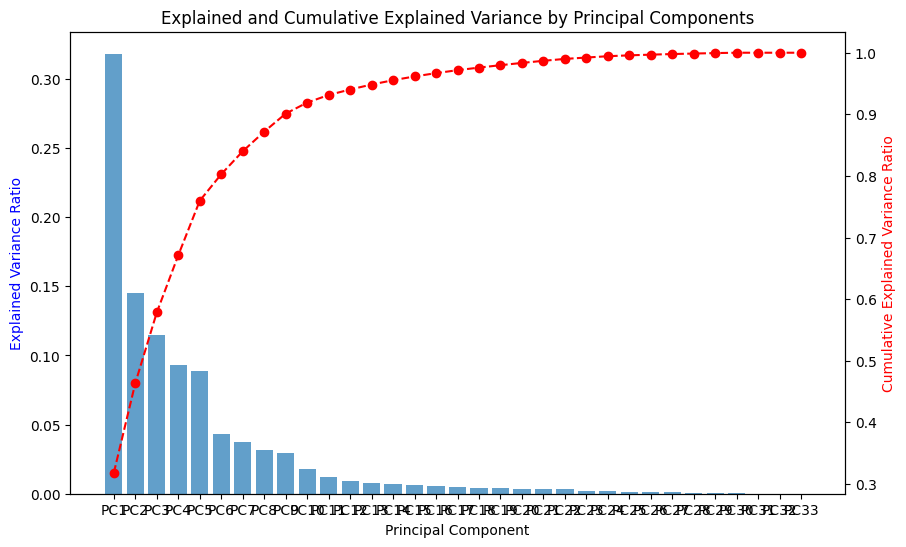

In [60]:

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the data
X_standardized = scaler.fit_transform(X)

# Apply PCA
pca = PCA()
pca.fit(X_standardized)

# Calculate the explained variance
explained_variance = pca.explained_variance_ratio_

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance)

# Plot the explained variance and cumulative explained variance on the same figure with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the explained variance
ax1.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, align='center')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio', color='b')
ax1.set_title('Explained and Cumulative Explained Variance by Principal Components')
ax1.set_xticks(range(1, len(explained_variance) + 1))
ax1.set_xticklabels([f'PC{i}' for i in range(1, len(explained_variance) + 1)])

# Create a second y-axis for the cumulative explained variance
ax2 = ax1.twinx()
ax2.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--', color='r')
ax2.set_ylabel('Cumulative Explained Variance Ratio', color='r')

plt.show()

In [61]:
# n_components = 6 # Change this value as needed
# # Apply PCA
# pca = PCA(n_components=n_components)
# X_pca = pca.fit_transform(X_standardized)

# # Split the data into train and test sets
# X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# print(f"Training set shape of pca reduced data: {X_train_pca.shape}")
# print(f"Test set shape of pca reduced data: {X_test_pca.shape}")
# # Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_standardized, y, test_size=0.2, random_state=42)

print(f"Training set shape : {X_train.shape}")
print(f"Test set shape: {X_test.shape}")



Training set shape : (11732, 33)
Test set shape: (2934, 33)



# Model selection/implementation



## SVM


Kernel: rbf
Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       467
           2       1.00      1.00      1.00       510
           3       1.00      1.00      1.00       497
           4       1.00      1.00      1.00       469
           5       1.00      1.00      1.00       478
           6       1.00      1.00      1.00       513

    accuracy                           1.00      2934
   macro avg       1.00      1.00      1.00      2934
weighted avg       1.00      1.00      1.00      2934

Model with rbf kernel saved as models/rbf_svm_9.pkl



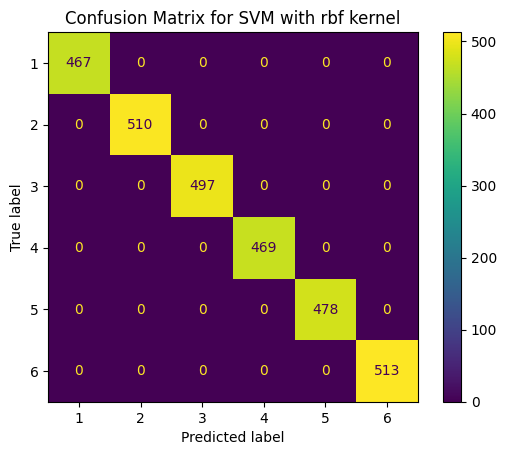

Kernel: linear
Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       467
           2       1.00      1.00      1.00       510
           3       1.00      1.00      1.00       497
           4       1.00      1.00      1.00       469
           5       1.00      1.00      1.00       478
           6       1.00      1.00      1.00       513

    accuracy                           1.00      2934
   macro avg       1.00      1.00      1.00      2934
weighted avg       1.00      1.00      1.00      2934

Model with linear kernel saved as models/linear_svm_2.pkl



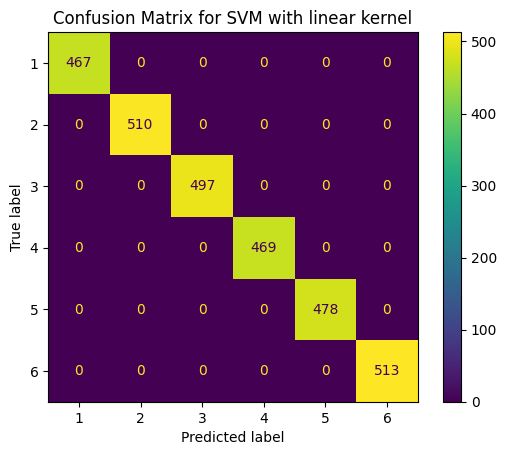

Kernel: poly
Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       467
           2       0.99      1.00      1.00       510
           3       1.00      0.99      1.00       497
           4       1.00      1.00      1.00       469
           5       1.00      1.00      1.00       478
           6       1.00      1.00      1.00       513

    accuracy                           1.00      2934
   macro avg       1.00      1.00      1.00      2934
weighted avg       1.00      1.00      1.00      2934

Model with poly kernel saved as models/poly_svm_4.pkl



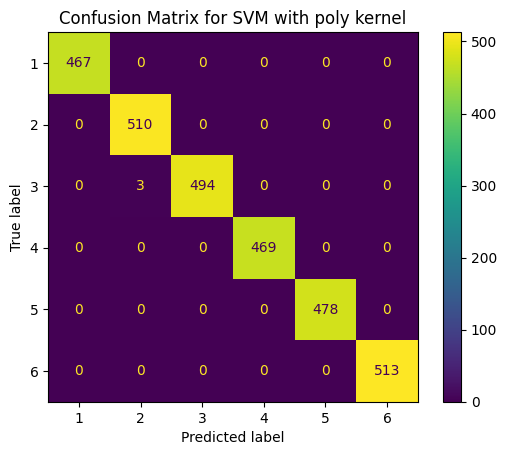

Kernel: sigmoid
Accuracy: 0.78
Classification Report:
              precision    recall  f1-score   support

           1       0.97      1.00      0.98       467
           2       0.62      0.78      0.69       510
           3       0.75      0.70      0.72       497
           4       0.75      0.65      0.70       469
           5       0.74      0.72      0.73       478
           6       0.94      0.86      0.90       513

    accuracy                           0.78      2934
   macro avg       0.79      0.78      0.79      2934
weighted avg       0.79      0.78      0.79      2934

Model with sigmoid kernel saved as models/sigmoid_svm_2.pkl



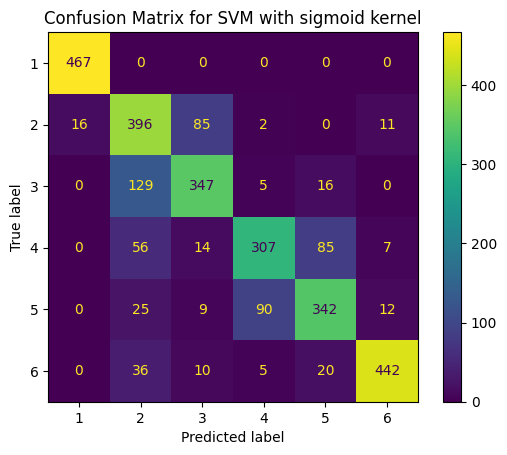

In [70]:
from sklearn.metrics import ConfusionMatrixDisplay

# Define the directory and base filename
model_dir = 'models'
os.makedirs(model_dir, exist_ok=True)

# Define the different kernels to train

kernels = ['rbf','linear', 'poly', 'sigmoid']



# Iterate over each kernel type
for kernel in kernels:
    # Initialize the SVM model with the specified kernel
    svm_model = SVC(kernel=kernel,tol=1e-4,C=100)
    
    # Train the model on the PCA-reduced training data
    svm_model.fit(X_train, y_train)
    
    # Make predictions on the PCA-reduced test data
    y_pred = svm_model.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    print(f"Kernel: {kernel}")
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:")
    print(report)
    
    # Prepare the model filename with kernel name
    version = 1
    while True:
        model_filename = f"{kernel}_svm_{version}.pkl"
        model_path = os.path.join(model_dir, model_filename)
        if not os.path.exists(model_path):
            break
        version += 1

    # Save the model and training loss
    with open(model_path, 'wb') as f:
        pickle.dump({'model': svm_model}, f)

    print(f"Model with {kernel} kernel saved as {model_path}\n")
    # Plot the confusion matrix
    ConfusionMatrixDisplay.from_estimator(svm_model, X_test, y_test)
    plt.title(f'Confusion Matrix for SVM with {kernel} kernel')
    plt.show()


In [63]:
# version = 1
# kernel = 'linear'
# while True:
#         model_filename = f"{kernel}_svm_{version}.pkl"
#         model_path = os.path.join(model_dir, model_filename)
#         if  os.path.exists(model_path):
#             break
#         version += 1

# # Load the pickled model
# with open(model_path, 'rb') as f:
#     loaded_model = pickle.load(f)['model']

# # Make predictions on the test data
# y_pred_loaded = loaded_model.predict(X_test_pca)

# # Evaluate the model
# accuracy_loaded = accuracy_score(y_test_pca, y_pred_loaded)
# report_loaded = classification_report(y_test_pca, y_pred_loaded)

# print(f"Loaded Model Accuracy: {accuracy_loaded:.2f}")
# print("Loaded Model Classification Report:")
# print(report_loaded)

In [64]:

# Define the directory and base filename
model_dir = 'models'
os.makedirs(model_dir, exist_ok=True)

# Define the different neighbor values to train
neighbor_values = [3, 5, 7]  # You can add more values as needed

# Iterate over each neighbor value
for n_neighbors in neighbor_values:
    # Initialize the KNN model with the specified number of neighbors
    knn_model = KNeighborsClassifier(n_neighbors=n_neighbors)
    
    # Train the model on the PCA-reduced training data
    knn_model.fit(X_train, y_train)
    
    # Make predictions on the PCA-reduced test data
    y_pred = knn_model.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    print(f"Number of Neighbors: {n_neighbors}")
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:")
    print(report)
    
    # Prepare the model filename with n_neighbors
    version = 1
    while True:
        model_filename = f"knn_{n_neighbors}_neighbors_{version}.pkl"
        model_path = os.path.join(model_dir, model_filename)
        if not os.path.exists(model_path):
            break
        version += 1

    # Save the model
    with open(model_path, 'wb') as f:
        pickle.dump({'model': knn_model}, f)

    print(f"Model with {n_neighbors} neighbors saved as {model_path}\n")


Number of Neighbors: 3
Accuracy: 0.99
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       467
           2       0.99      1.00      1.00       510
           3       1.00      0.99      0.99       497
           4       0.98      0.97      0.97       469
           5       0.97      0.98      0.98       478
           6       1.00      1.00      1.00       513

    accuracy                           0.99      2934
   macro avg       0.99      0.99      0.99      2934
weighted avg       0.99      0.99      0.99      2934

Model with 3 neighbors saved as models/knn_3_neighbors_3.pkl

Number of Neighbors: 5
Accuracy: 0.99
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       467
           2       1.00      0.99      0.99       510
           3       0.99      0.99      0.99       497
           4       0.98      0.98      0.98       469
  